In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import warnings
warnings.filterwarnings('ignore')

In [2]:
my_data_dir = 'C:\\Users\Harish Krishna\Desktop\FINAL_TF2_FILES\TF_2_Notebooks_and_Data\DATA\cell_images\cell_images'

In [3]:
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

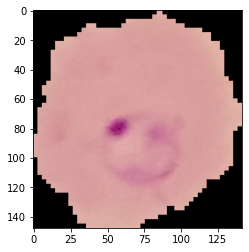

In [8]:
infected_cell_path = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'
infected_cell= imread(infected_cell_path)
plt.imshow(infected_cell)

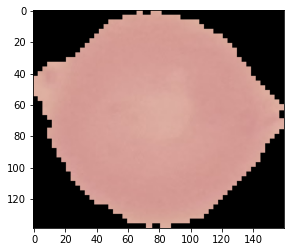

In [9]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [10]:
infected_cell.shape

(148, 142, 3)

In [11]:
unifected_cell.shape

(139, 160, 3)

In [12]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [13]:
len(os.listdir(train_path+'\\uninfected'))

12480

Finding the dimensions of uninfected 

In [14]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

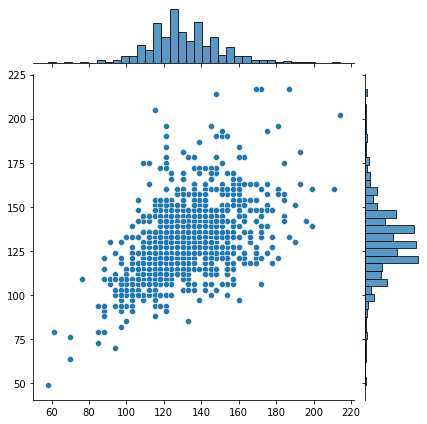

In [15]:
sns.jointplot(dim1,dim2)

Averaging the dimensions

In [16]:
np.mean(dim1)

130.92538461538462

In [17]:
np.mean(dim2)

130.75

In [18]:
image_shape = (130,130,3)

It is done because CNN will not be able to train with images of different sizes, for smaller photos padding can be done and if it is larger pics cropping can be done 

## Preparing the Data for the model

Image Data Generator is generally used for image data generation and manipulation 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.preprocessing.image:

class ImageDataGenerator(keras_preprocessing.image.image_data_generator.ImageDataGenerator)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |   The data will be looped over (in batches).
 |  
 |  Args:
 |      featurewise_center: Boolean.
 |          Set input mean to 0 over the dataset, feature-wise.
 |      samplewise_center: Boolean. Set each sample mean to 0.
 |      featurewise_s

As the number of images are bit lower we are rotating the images such that each rotated image is considered to be a distinct image

In [21]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

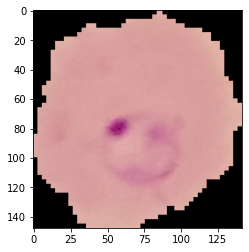

In [22]:
plt.imshow(infected_cell)

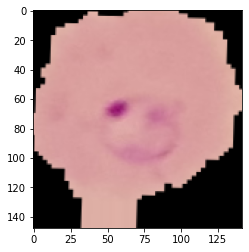

In [23]:
plt.imshow(image_gen.random_transform(infected_cell))

In [24]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [25]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [27]:
image_shape

(130, 130, 3)

In [28]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [32]:
batch_size = 16

In [33]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [34]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [35]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [36]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 388s 248ms/step - loss: 0.3554 - accuracy: 0.8469 - val_loss: 0.2050 - val_accuracy: 0.9235
Epoch 2/20
1560/1560 [==============================] - 353s 226ms/step - loss: 0.1819 - accuracy: 0.9426 - val_loss: 0.1977 - val_accuracy: 0.9404
Epoch 3/20
1560/1560 [==============================] - 373s 239ms/step - loss: 0.1673 - accuracy: 0.9474 - val_loss: 0.1607 - val_accuracy: 0.9485
Epoch 4/20
1560/1560 [==============================] - 345s 221ms/step - loss: 0.1658 - accuracy: 0.9478 - val_loss: 0.1688 - val_accuracy: 0.9450
Epoch 5/20
1560/1560 [==============================] - 342s 219ms/step - loss: 0.1625 - accuracy: 0.9494 - val_loss: 0.1471 - val_accuracy: 0.9515
Epoch 6/20
1560/1560 [==============================] - 352s 226ms/step - loss: 0.1587 - accuracy: 0.9505 - val_loss: 0.1699 - val_accuracy: 0.9442
Epoch 7/20
1560/1560 [==============================] - 357s 229ms/step - loss: 0.1547 - accuracy: 0.9518 - val_

<AxesSubplot:>

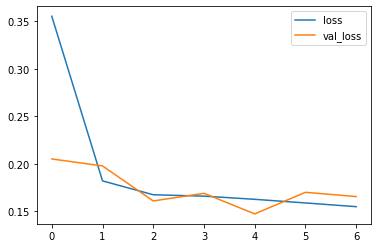

In [44]:
losses = pd.DataFrame(results.history)
losses[['loss','val_loss']].plot()

In [37]:
# from tensorflow.keras.models import load_model
# model.save('malaria_detector.h5')

In [46]:
model.evaluate_generator(test_image_gen)

[0.16273458302021027, 0.9496153593063354]

In [48]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [49]:
pred_probabilities

array([[9.7048596e-06],
       [6.4458596e-05],
       [3.0115247e-04],
       ...,
       [9.5121741e-01],
       [9.9104738e-01],
       [9.9045992e-01]], dtype=float32)

In [50]:
predictions = pred_probabilities > 0.5

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

In [52]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [53]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1217,   83],
       [  51, 1249]], dtype=int64)

# Predicting on image

In [47]:
from tensorflow.keras.preprocessing import image

In [55]:
infected_cell_path

'C:\\Users\\Harish Krishna\\Desktop\\FINAL_TF2_FILES\\TF_2_Notebooks_and_Data\\DATA\\cell_images\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [56]:
my_image = image.load_img(infected_cell_path,target_size=image_shape)

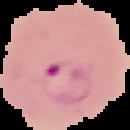

In [57]:
my_image

In [58]:
type(my_image)

PIL.Image.Image

In [59]:
my_image = image.img_to_array(my_image)

In [60]:
type(my_image)

numpy.ndarray

In [61]:
my_image.shape

(130, 130, 3)

In [62]:
my_image = np.expand_dims(my_image, axis=0)

In [63]:
my_image.shape

(1, 130, 130, 3)

In [64]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [65]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [66]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}